In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)

Loading required package: ggplot2

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: Matrix


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
# Make sure that these files are in the current working directory
tissue.meta.data = read.csv('tissue_object_metadata.csv', header =1, stringsAsFactors = FALSE, row.names = 1)
eos.meta.data = read.csv('eosinophil_object_metadata.csv', header =1, stringsAsFactors = FALSE, row.names = 1)
tcelle.meta.data =read.csv('esophagus_tcell_metadata.csv', header =1, stringsAsFactors = FALSE, row.names = 1)
tcelld.meta.data =read.csv('duodenum_tcell_metadata.csv', header =1, stringsAsFactors = FALSE, row.names = 1)
pb.meta.data = read.csv('pb_metadata.csv', header =1, stringsAsFactors = FALSE, row.names = 1)

In [3]:
library(stringr)
# Make sure the GEO data (un-tarred and decompressed is in this folder)
files = list.files('../GEO')
setwd('../GEO')
sample.name = sapply(files, function(x) str_split(x, '_')[[1]][1])
files.master = files[!duplicated(sample.name)]
patients.master = sapply(files.master, function(x) str_split(x, '_')[[1]][2])
sample.type.master = sapply(files.master, function(x) str_split(x, '_')[[1]][3])

In [4]:
# identify files from tissue samples
tissue.files = files.master[sample.type.master %in% c('Esophagus', 'Duodenum')]
tissue.files

[1] "GSM5351369_P471_Esophagus_barcodes.tsv"
 [2] "GSM5351370_P471_Duodenum_barcodes.tsv" 
 [3] "GSM5351371_P354_Esophagus_barcodes.tsv"
 [4] "GSM5351372_P354_Duodenum_barcodes.tsv" 
 [5] "GSM5351373_P468_Esophagus_barcodes.tsv"
 [6] "GSM5351374_P468_Duodenum_barcodes.tsv" 
 [7] "GSM5351375_P451_Esophagus_barcodes.tsv"
 [8] "GSM5351376_P451_Duodenum_barcodes.tsv" 
 [9] "GSM5351377_P474_Esophagus_barcodes.tsv"
[10] "GSM5351378_P474_Duodenum_barcodes.tsv" 
[11] "GSM5351379_P475_Esophagus_barcodes.tsv"
[12] "GSM5351380_P475_Duodenum_barcodes.tsv" 
[13] "GSM5351381_P249_Esophagus_barcodes.tsv"
[14] "GSM5351382_P249_Duodenum_barcodes.tsv" 
[15] "GSM5351383_P392_Esophagus_barcodes.tsv"
[16] "GSM5351384_P392_Duodenum_barcodes.tsv" 
[17] "GSM5351385_P292_Esophagus_barcodes.tsv"
[18] "GSM5351386_P292_Duodenum_barcodes.tsv" 
[19] "GSM5351387_P355_Esophagus_barcodes.tsv"
[20] "GSM5351388_P355_Duodenum_barcodes.tsv"

In [5]:
# parse and combine data from tissue samples
for (x in tissue.files){
    message(x)
    sample = str_split(x, '_')[[1]][1]
    sample.files = list.files(pattern = sample)
    curr_patient = str_split(sample.files[1], '_')[[1]][2]
    curr_tissue = str_split(sample.files[1], '_')[[1]][3]

    sample.files.formatted = sapply(sample.files, function(x) str_split(x, '_')[[1]][4])
    dir.create(sample)
    for (i in 1:length(sample.files)) {
        file.copy(sample.files[i], paste0(sample, '/', sample.files.formatted[i]))
    }
    

    curr_data = Read10X(sample)
        
    # this just makes sure that the correct annotations are matching up with the correct cells
    curr_metadata = tissue.meta.data %>% filter(patient == curr_patient, tissue == curr_tissue)
    nUMI = colSums(curr_data)
    curr_data = curr_data[,order(colnames(curr_data), nUMI)]
    curr_metadata = curr_metadata[order(curr_metadata$bc, curr_metadata$nUMI),]
    colnames(curr_data) = paste0(colnames(curr_data), 1:length(colnames(curr_data)))

    if (x == tissue.files[1]) {
        data = curr_data
        metadata = curr_metadata
    }
    else {
        data = cbind(data, curr_data)
        metadata = rbind(metadata, curr_metadata)
    }
}
                                    
        

GSM5351369_P471_Esophagus_barcodes.tsv

GSM5351370_P471_Duodenum_barcodes.tsv

GSM5351371_P354_Esophagus_barcodes.tsv

GSM5351372_P354_Duodenum_barcodes.tsv

GSM5351373_P468_Esophagus_barcodes.tsv

GSM5351374_P468_Duodenum_barcodes.tsv

GSM5351375_P451_Esophagus_barcodes.tsv

GSM5351376_P451_Duodenum_barcodes.tsv

GSM5351377_P474_Esophagus_barcodes.tsv

GSM5351378_P474_Duodenum_barcodes.tsv

GSM5351379_P475_Esophagus_barcodes.tsv

GSM5351380_P475_Duodenum_barcodes.tsv

GSM5351381_P249_Esophagus_barcodes.tsv

GSM5351382_P249_Duodenum_barcodes.tsv

GSM5351383_P392_Esophagus_barcodes.tsv

GSM5351384_P392_Duodenum_barcodes.tsv

GSM5351385_P292_Esophagus_barcodes.tsv

GSM5351386_P292_Duodenum_barcodes.tsv

GSM5351387_P355_Esophagus_barcodes.tsv

GSM5351388_P355_Duodenum_barcodes.tsv



In [6]:
# create Seurat object and manually set cell names
colnames(data) = metadata$cellname
tissue_seurat = CreateSeuratObject(data, project = 'EoETissue', min.cells = 0, min.genes= 0)
tissue_seurat@meta.data = metadata
rownames(tissue_seurat@meta.data) = metadata$cellname

Regressing out: nGene, percent.mito




Time Elapsed:  2.40088541507721 mins

Scaling data matrix



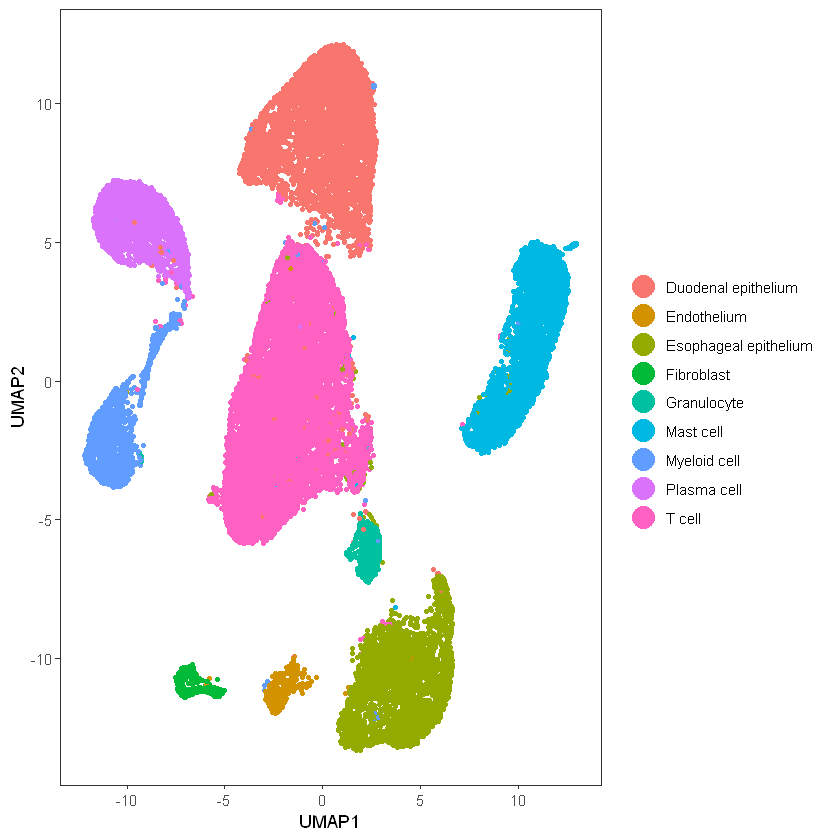

In [7]:
# process seurat object and add UMAP coordinates
tissue_seurat = NormalizeData(tissue_seurat)
tissue_seurat = FindVariableGenes(tissue_seurat, do.plot = FALSE)
tissue_seurat = ScaleData(tissue_seurat, genes.use = tissue_seurat@var.genes, model.use = 'poisson', vars.to.regress = c('nGene', 'percent.mito'))
tissue_seurat = RunPCA(tissue_seurat, do.print = FALSE)
tissue_seurat = RunUMAP(tissue_seurat, dims.use = 1:10)
attributes(tissue_seurat@dr$umap)$cell.embeddings = as.matrix(tissue_seurat@meta.data[,c("UMAP1", 'UMAP2')])
DimPlot(tissue_seurat, 'umap', group.by = 'phenotype')

Regressing out: nGene, percent.mito




Time Elapsed:  22.5913889408112 secs

Scaling data matrix



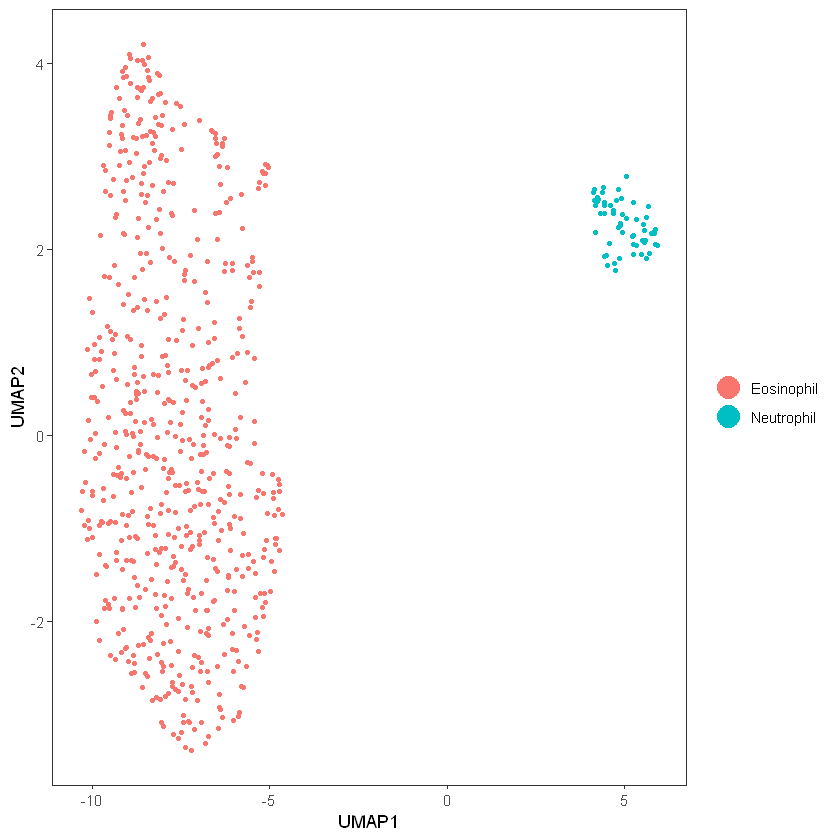

In [8]:
# create eosinophil object
eos = SubsetData(tissue_seurat, rownames(eos.meta.data))
eos@meta.data = eos.meta.data[eos@cell.names,]
eos = NormalizeData(eos)
eos = FindVariableGenes(eos, do.plot = FALSE)
eos = ScaleData(eos, genes.use = eos@var.genes, model.use = 'poisson', vars.to.regress = c('nGene', 'percent.mito'))
eos = RunPCA(eos, do.print = FALSE)
eos = RunUMAP(eos, dims.use = 1:10)
attributes(eos@dr$umap)$cell.embeddings = as.matrix(eos@meta.data[,c("UMAP1", 'UMAP2')])
DimPlot(eos, 'umap', group.by = 'sub_phenotype')

Regressing out: nGene, percent.mito




Time Elapsed:  33.5163300037384 secs

Scaling data matrix



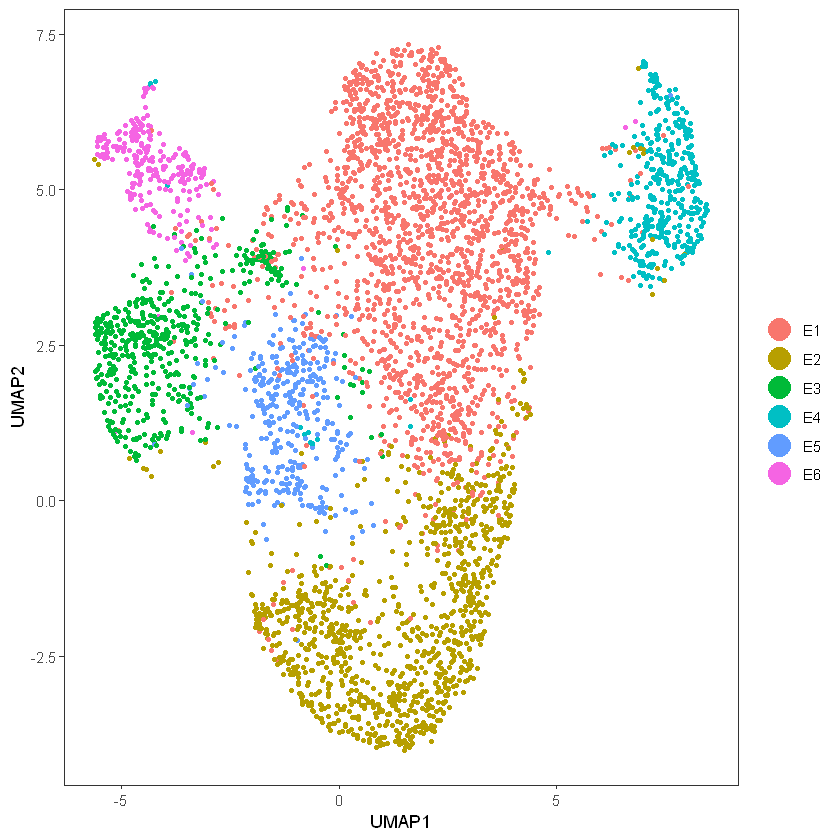

In [9]:
# create esophageal T cell object
tcelle = SubsetData(tissue_seurat, rownames(tcelle.meta.data))
tcelle@meta.data = tcelle.meta.data[tcelle@cell.names,]
tcelle = NormalizeData(tcelle)
tcelle = FindVariableGenes(tcelle, do.plot = FALSE)
tcelle = ScaleData(tcelle, genes.use = tcelle@var.genes, model.use = 'poisson', vars.to.regress = c('nGene', 'percent.mito'))
tcelle = RunPCA(tcelle, do.print = FALSE)
tcelle = RunUMAP(tcelle, dims.use = 1:10)
attributes(tcelle@dr$umap)$cell.embeddings = as.matrix(tcelle@meta.data[,c("UMAP1", 'UMAP2')])
DimPlot(tcelle, 'umap', group.by = 'plot_cluster')

Regressing out: nGene, percent.mito




Time Elapsed:  22.6645081043243 secs

Scaling data matrix



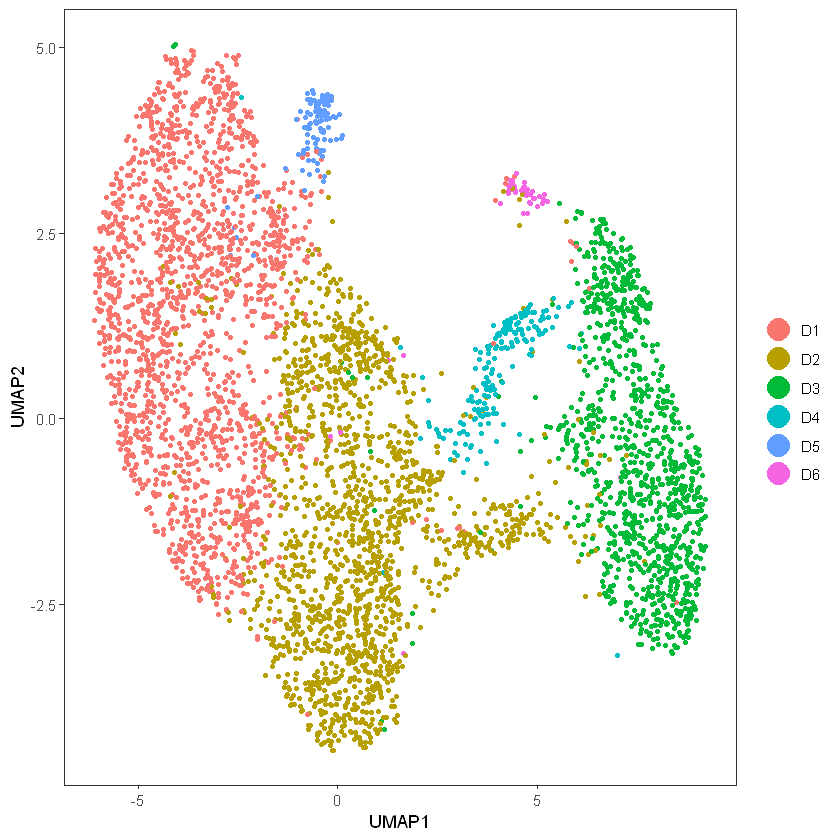

In [10]:
# create duodenal T cell object
tcelld = SubsetData(tissue_seurat, rownames(tcelld.meta.data))
tcelld@meta.data = tcelld.meta.data[tcelld@cell.names,]
tcelld = NormalizeData(tcelld)
tcelld = FindVariableGenes(tcelld, do.plot = FALSE)
tcelld = ScaleData(tcelld, genes.use = tcelld@var.genes, model.use = 'poisson', vars.to.regress = c('nGene', 'percent.mito'))
tcelld = RunPCA(tcelld, do.print = FALSE)
tcelld = RunUMAP(tcelld, dims.use = 1:10)
attributes(tcelld@dr$umap)$cell.embeddings = as.matrix(tcelld@meta.data[,c("UMAP1", 'UMAP2')])
DimPlot(tcelld, 'umap', group.by = 'plot_cluster')

In [11]:
# identify files from peripheral blood
pb.files = files.master[!sample.type.master %in% c('Esophagus', 'Duodenum')]
pb.files

[1] "GSM5394603_P292_CRTH2+CD161+_barcodes.tsv"
 [2] "GSM5394604_P292_CRTH2+CD161-_barcodes.tsv"
 [3] "GSM5394605_P292_CRTH2-CD161-_barcodes.tsv"
 [4] "GSM5394606_P354_CRTH2+CD161+_barcodes.tsv"
 [5] "GSM5394607_P354_CRTH2+CD161-_barcodes.tsv"
 [6] "GSM5394608_P354_CRTH2-CD161-_barcodes.tsv"
 [7] "GSM5394609_P355_CRTH2+CD161+_barcodes.tsv"
 [8] "GSM5394610_P355_CRTH2+CD161-_barcodes.tsv"
 [9] "GSM5394611_P355_CRTH2-CD161-_barcodes.tsv"
[10] "GSM5394612_P392_CRTH2+CD161+_barcodes.tsv"
[11] "GSM5394613_P392_CRTH2+CD161-_barcodes.tsv"
[12] "GSM5394614_P392_CRTH2-CD161-_barcodes.tsv"
[13] "GSM5394615_P451_CRTH2+CD161+_barcodes.tsv"
[14] "GSM5394616_P451_CRTH2+CD161-_barcodes.tsv"
[15] "GSM5394617_P451_CRTH2-CD161-_barcodes.tsv"
[16] "GSM5394618_P468_CRTH2+CD161+_barcodes.tsv"
[17] "GSM5394619_P468_CRTH2+CD161-_barcodes.tsv"
[18] "GSM5394620_P468_CRTH2-CD161-_barcodes.tsv"
[19] "GSM5394621_P474_CRTH2+CD161+_barcodes.tsv"
[20] "GSM5394622_P474_CRTH2+CD161-_barcodes.tsv"
[21] "GSM5394623_P474_CRTH2-CD161-_barcodes.tsv"
[22] "GSM5394624_P475_CRTH2+CD161+_barcodes.tsv"
[23] "GSM5394625_P475_CRTH2+CD161-_barcodes.tsv"
[24] "GSM5394626_P475_CRTH2-CD161-_barcodes.tsv"

In [12]:
# parse and combine files from peripheral blood
for (x in pb.files){
    message(x)
    sample = str_split(x, '_')[[1]][1]
    sample.files = list.files(pattern = sample)
    curr_patient = str_split(sample.files[1], '_')[[1]][2]
    curr_fraction = str_split(sample.files[1], '_')[[1]][3]

    sample.files.formatted = sapply(sample.files, function(x) str_split(x, '_')[[1]][4])
    dir.create(sample)
    for (i in 1:length(sample.files)) {
        file.copy(sample.files[i], paste0(sample, '/', sample.files.formatted[i]))
    }
    

    curr_data = Read10X(sample)
    curr_fraction = gsub(x = curr_fraction, pattern = 'CD161', replacement = ' CD161')
    # this just makes sure that the correct annotations are matching up with the correct cells
    curr_metadata = pb.meta.data %>% filter(Patient == curr_patient, Fraction == curr_fraction)
    nUMI = colSums(curr_data)
    curr_data = curr_data[,order(colnames(curr_data), nUMI)]
    curr_metadata = curr_metadata[order(curr_metadata$bcs, curr_metadata$nUMI),]
    colnames(curr_data) = paste0(colnames(curr_data), 1:length(colnames(curr_data)))

    if (x == pb.files[1]) {
        data = curr_data
        metadata = curr_metadata
    }
    else {
        data = cbind(data, curr_data)
        metadata = rbind(metadata, curr_metadata)
    }
}
                                    
        

GSM5394603_P292_CRTH2+CD161+_barcodes.tsv

GSM5394604_P292_CRTH2+CD161-_barcodes.tsv

GSM5394605_P292_CRTH2-CD161-_barcodes.tsv

GSM5394606_P354_CRTH2+CD161+_barcodes.tsv

GSM5394607_P354_CRTH2+CD161-_barcodes.tsv

GSM5394608_P354_CRTH2-CD161-_barcodes.tsv

GSM5394609_P355_CRTH2+CD161+_barcodes.tsv

GSM5394610_P355_CRTH2+CD161-_barcodes.tsv

GSM5394611_P355_CRTH2-CD161-_barcodes.tsv

GSM5394612_P392_CRTH2+CD161+_barcodes.tsv

GSM5394613_P392_CRTH2+CD161-_barcodes.tsv

GSM5394614_P392_CRTH2-CD161-_barcodes.tsv

GSM5394615_P451_CRTH2+CD161+_barcodes.tsv

GSM5394616_P451_CRTH2+CD161-_barcodes.tsv

GSM5394617_P451_CRTH2-CD161-_barcodes.tsv

GSM5394618_P468_CRTH2+CD161+_barcodes.tsv

GSM5394619_P468_CRTH2+CD161-_barcodes.tsv

GSM5394620_P468_CRTH2-CD161-_barcodes.tsv

GSM5394621_P474_CRTH2+CD161+_barcodes.tsv

GSM5394622_P474_CRTH2+CD161-_barcodes.tsv

GSM5394623_P474_CRTH2-CD161-_barcodes.tsv

GSM5394624_P475_CRTH2+CD161+_barcodes.tsv

GSM5394625_P475_CRTH2+CD161-_barcodes.tsv

GSM5394626_

In [13]:
# create seurat object from peripehral blood
colnames(data) = metadata$cellname
pb = CreateSeuratObject(data, project = 'EoEPeriphery', min.cells = 0, min.genes= 0)
pb@meta.data = metadata
rownames(pb@meta.data) = metadata$cellname

Regressing out: nGene




Time Elapsed:  1.80040060281754 mins

Scaling data matrix



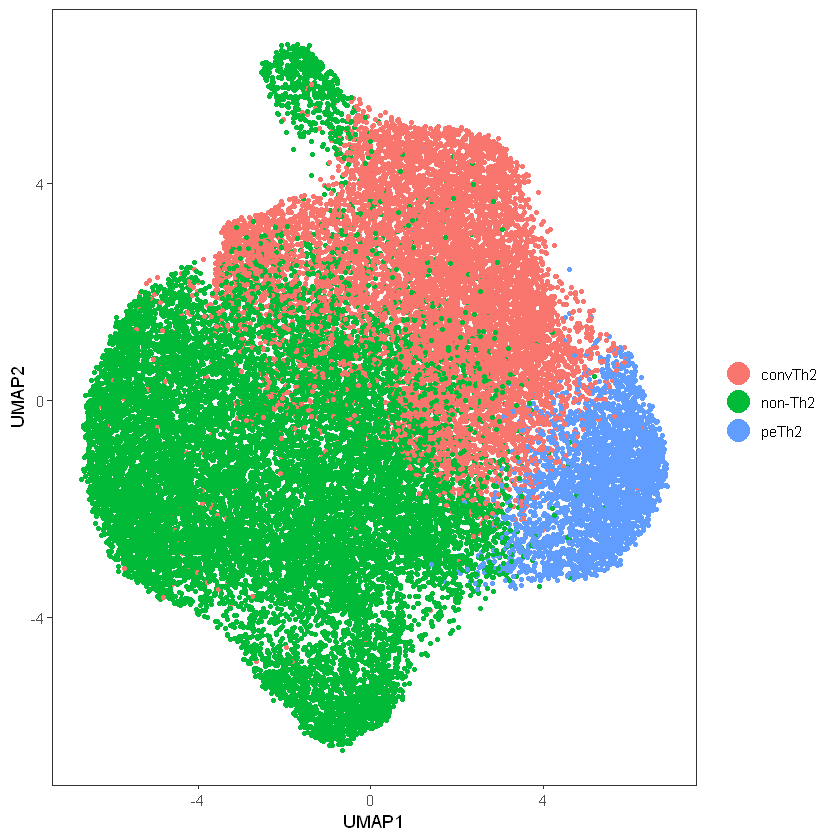

In [14]:
# process seurat object from peripheral blood
pb = NormalizeData(pb)
pb = FindVariableGenes(pb, do.plot = FALSE)
pb = ScaleData(pb, genes.use = pb@var.genes, model.use = 'poisson', vars.to.regress = c('nGene'))
pb = RunPCA(pb, do.print = FALSE)
pb = RunUMAP(pb, dims.use = 1:10)
attributes(pb@dr$umap)$cell.embeddings = as.matrix(pb@meta.data[,c("UMAP1", 'UMAP2')])
DimPlot(pb, 'umap', group.by = 'phenotype')

In [15]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows Server x64 (build 14393)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] stringr_1.4.0 dplyr_0.8.5   Seurat_2.3.4  Matrix_1.2-18 cowplot_1.0.0
[6] ggplot2_3.3.0

loaded via a namespace (and not attached):
  [1] uuid_0.1-4          snow_0.4-3          backports_1.1.6    
  [4] Hmisc_4.4-0         sn_1.6-1            plyr_1.8.6         
  [7] igraph_1.2.5        repr_1.1.0          splines_3.6.3      
 [10] TH.data_1.0-10      digest_0.6.25       foreach_1.5.0      
 [13] htmltools_0.4.0     lars_1.2            gdata_2.18.0       
 [16] magrittr_1.5        checkmate_2.0.